Shortened workbench for analysing the shapefiles using pandas

In [90]:
from sinuutils import readshapestopandas

riverid = 1 # id of channel being analysed (CM_riverid)
#channelname = 'sinuosity_shapefiles/sin_CM5_no2012.shp'
channelname = 'sinuosity_shapefiles/sin_CM%d.shp' % riverid # define channel to be analysed
yearrivers = readshapestopandas(channelname)
# in yearrivers shapeid from readshapestopandas is the year that the profile was drawn


In [91]:
# import shapefile which contains the valley slopes for different years

valleyslope = 'sinuosity_shapefiles/valley_slope_prof_wgs84.shp'

direct_profiles = readshapestopandas(valleyslope)

# in this shapefile, the 'shapeid' is not a year but the id of the channel
# call the correct channel id using riverid

direct_profile = None
for shapeid, d in direct_profiles:
    if shapeid == riverid:
        direct_profile = d

# direct_profile  - uncomment out to see dataset

Text(0, 0.5, 'y position [m]')

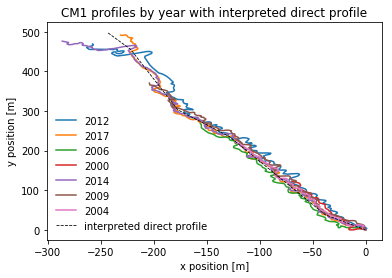

In [92]:
%matplotlib inline 
from matplotlib import pyplot as plt

for year, df in yearrivers:
    plt.plot(df.x, df.y, label='%d' % year)
    
plt.plot(direct_profile.x, direct_profile.y, color='k',linestyle='--',linewidth=0.8, label='interpreted direct profile')
#plt.axis('equal')
plt.legend(loc='lower left',frameon=False)  
plt.title('CM%d profiles by year with interpreted direct profile' % riverid)
plt.xlabel('x position [m]')
plt.ylabel('y position [m]')

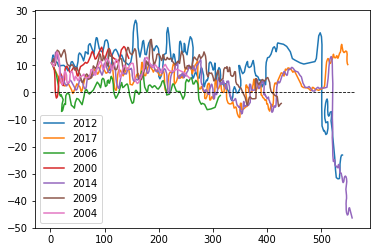

In [93]:
from sinuutils import transaxis
from sinuutils import warptodirect
import numpy as np
    
for year, df in yearrivers:
    straightenedx, straightenedy, cwtx, cwty, r0,r1 = warptodirect(direct_profile, df)
    plt.plot(straightenedx, straightenedy, label="%d" % year)
    
transax = np.linspace(0,r1,10)
transay = np.zeros((10,), dtype=int)
    
plt.plot(transax, transay, color='k', linestyle='--', linewidth=0.8)
plt.legend(loc='lower left')


need to resample distances along the path using np.interp so that window size is consistent in the next section and bears some relevance to reality

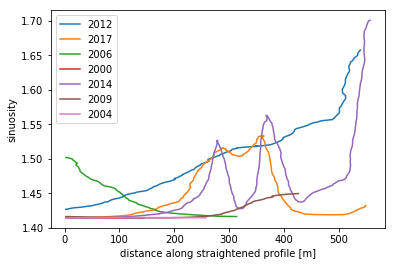

In [94]:
# calculate windowed sinuosity of the river channel
from sinuutils import makeweightseries
from sinuutils import windowed_sinuosity

# calculate windowed sinuosity for each given year
for year, df in yearrivers:
    wxs, awsin = windowed_sinuosity(df)
    plt.plot(df.straightenedx,df.windowedsin, label='%d' %year)
    
plt.xlabel('distance along straightened profile [m]')
plt.ylabel('sinuosity')
plt.legend()


In [95]:
#yearrivers - uncomment to see full dataframe

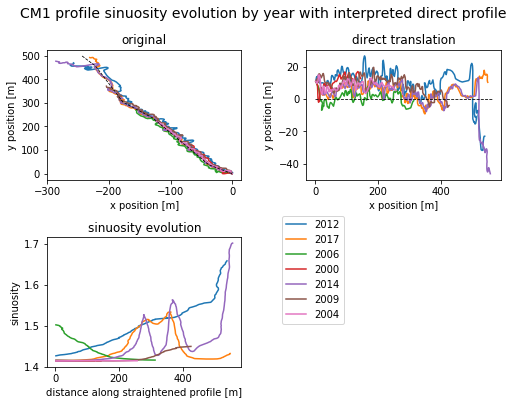

In [96]:
# plot all diagrams for channel so far in one figure and save the figure

#fig, axs = plt.subplots(nrows=2, ncols=2, constrained_layout=True)
fig = plt.figure()
fig.suptitle('CM%d profile sinuosity evolution by year with interpreted direct profile' % riverid, x=0.6, y=1.35, fontsize=14)

ax1 = fig.add_axes([0.1, 0.75, 0.45, 0.45])
for year, df in yearrivers:
    p_yrs = ax1.plot(df.x, df.y, label='%d' % year)

fig.legend(loc=[0.55, 0.2])    

ax1.plot(direct_profile.x, direct_profile.y, color='k',linestyle='--', linewidth=0.8)
#plt.legend(loc='lower left',frameon=False)  
#plt.title('CM%d profiles by year with interpreted direct profile' % riverid)
plt.xlabel('x position [m]')
plt.ylabel('y position [m]')
plt.title('original')

ax2 = fig.add_axes([0.7, 0.75, 0.45, 0.45])

for year, df in yearrivers:
    ax2.plot(df.straightenedx, df.straightenedy)
ax2.plot(transax, transay, color='k', linestyle='--', linewidth=0.8, label='translation axis')
plt.xlabel('x position [m]')
plt.ylabel('y position [m]')
plt.title('direct translation')

ax3 = fig.add_axes([0.1, 0.1, 0.45, 0.45])

for year, df in yearrivers:
    ax3.plot(df.straightenedx,df.windowedsin)
      
plt.xlabel('distance along straightened profile [m]')
plt.ylabel('sinuosity')
plt.title('sinuosity evolution')

plt.savefig('sin_evo_CM%d.png' % riverid)





next step: plot heatmap of sinuosity with distance along channel (x axis) vs time (y axis)

In [52]:
# create a new dataframe storing sinuosity values for the channel according to year (rows) and 
# distance along the channel (columns)

import pandas as pd

reformed_df = [ ]
reformed_dfpivot = [ ]

for year, df in yearrivers:
    dftwo = pd.DataFrame({"xpos":df.straightenedx, "year":year, "sinuosity":df.windowedsin})
    reformed_df.append(dftwo)
    #dftwopivot = df_two.pivot(index='year', columns='xpos', values='sinuosity')
    #reformed_dfpivot.append(dftwopivot)


    



In [53]:
#df_two.pivot(index='year', columns='xpos', values='sinuosity')

In [54]:
# create heatmap of sinuosity with time along length of a given channel using seaborn

import seaborn as sns

# use pivot to revisualise dataset
sin_length_year = reformed_df.pivot(index='year', columns='xpos', values='sinuosity')

# set up the plot
fig, ax = plt.subplots(figsize=(10, 25))
sns.heatmap(reformed_df, cmap='RdYlGr', ax=ax)

AttributeError: 'list' object has no attribute 'pivot'

In [55]:
sin_length_year = df_two.pivot(index='year', columns='xpos', values='sinuosity')

ValueError: Index contains duplicate entries, cannot reshape

In [33]:
sin_length_year

xpos,6.729163507506086,24.585006547763882,29.269869682667643,32.11355715980002,35.55863694519482,38.518911363596686,39.91857262682771,44.193650999093485,48.58002844887904,48.92273022622772,...,90.2278904747375,91.76899723884755,92.28129505150766,93.44952097590176,94.84812461161927,95.86666798814377,96.89728128894177,98.00679580444944,100.59366117342695,102.3297521279719
year,,,,,,,,,,,,,,,,,,,,,
2009,1.479492,1.480476,1.481468,1.482468,1.483476,1.484491,1.485513,1.486542,1.487578,1.48862,...,1.525304,1.52632,1.527327,1.528322,1.529306,1.530278,1.531237,1.532183,1.533115,1.534033
